In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
top_level=f'{os.getcwd()}/..'

In [2]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=f'{top_level}/datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

In [261]:
def make_heatmap(filename,eventnum,normalize,showhistdiff,posrange,posrange2,bunchstart,bunchstop):
    ampFault, recordtime=datfile(filename)
    print(f'Recorded time : {recordtime}')
    print(f'Selected time : {recordtime[eventnum]}')
    
    def bunchindex(threshold,waveform):
        start=12800
        for i in range(1,8*2000):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(1000,ampFault[0][eventnum])
    print(f'Num of bunch : {len(bunch_index)}')
    print(f'First bunch index : {firstbunch}')
    start=12800
    y_pos=[]
    charge=[]
    for j in bunch_index:
        certain_bunch=[]
        certain_bunch_charge=[]
        for i in range(12):
            sum=ampFault[0][eventnum][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][eventnum][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
            certain_bunch_charge.append(sum)
        y_pos.append(np.array(certain_bunch))
        charge.append(np.array(certain_bunch_charge))
    y_pos=np.array(y_pos)
    charge=np.array(charge)

    aspectratio=y_pos.shape[1]/y_pos.shape[0]

    if normalize:
        mean=np.mean(y_pos[:,0:3],axis=1)
        y_pos=y_pos-mean[:,np.newaxis]
            
    
    fig=plt.figure(figsize=(20,20))
    plt.rcParams["font.size"]=16
    ax1=fig.add_subplot(2,2,1)
    ax2=fig.add_subplot(2,2,2)
    #ax3=fig.add_subplot(3,2,3,projection='3d')
    ax3=fig.add_subplot(2,2,3)
    ax4=fig.add_subplot(2,2,4)

    if normalize:
        im=ax1.imshow(y_pos,aspect=aspectratio*1.08,cmap='viridis',interpolation='none',extent=(0.5,12.5,y_pos.shape[0],0)
                      ,vmin=-1*posrange,vmax=posrange
                     )
    else:
        im=ax1.imshow(y_pos,aspect=aspectratio*1.08,cmap='viridis',interpolation='none',extent=(0.5,12.5,y_pos.shape[0],0),vmin=-1,vmax=1)
    plt.colorbar(im,label='Y position (mm)',shrink=0.88)
    ax1.set_xlabel("Turn")
    ax1.set_ylabel("Bunch ID")
    ax1.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    
    y_pos_diff=[]
    for i in range(y_pos.shape[0]):
        y_pos_diff.append(y_pos[i][1:]-y_pos[i][:-1])
        
    y_pos_diff=np.array(y_pos_diff)
    
    im2=ax2.imshow(y_pos_diff,aspect=aspectratio,cmap='coolwarm',interpolation='none',extent=(1.5,12.5,y_pos_diff.shape[0],0),vmin=-1*posrange2,vmax=posrange2)
    plt.colorbar(im2,label='Change in Y position from previous turn (mm)',shrink=0.88)
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Bunch ID")
    ax2.set_xticks([2,3,4,5,6,7,8,9,10,11,12])

    #x, y = np.meshgrid(np.arange(y_pos_diff.shape[1]), np.arange(y_pos_diff.shape[0]))
    #surface = ax3.plot_surface(x, y, y_pos_diff, cmap='viridis',edgecolor='k',rstride=5,cstride=5)
    #fig.colorbar(surface, ax=ax3, shrink=0.5, aspect=10)
    #ax3.view_init(30,300)
    #ax3.set_xlabel('Turn')
    #ax3.set_ylabel('Bunch ID')
    #ax3.set_zlabel('Y pos diff (mm)')
    #ax3.set_zlim(-1,1)
    """
    ax3.hist(np.concatenate(y_pos),bins=100,label="Y position")
    ax3.set_xlabel('Y position (mm)')
    if showhistdiff:
        ax3.hist(np.concatenate(y_pos_diff),bins=100,label="Y position diff")
        ax3.set_xlabel('Y position or change (mm)')
        ax3.legend()

    print(f'STD of Y position : {np.std(np.concatenate(y_pos))}')
    print(f'STD of Y position change : {np.std(np.concatenate(y_pos_diff))}')
    plt.show()
    """

    if normalize:
        charge_mean=np.mean(charge[:,0:3],axis=1)
        charge=charge/charge_mean[:,np.newaxis]

    if normalize:
        im3=ax3.imshow(charge,aspect=aspectratio*1.08,cmap='plasma',interpolation='none',extent=(0.5,12.5,charge.shape[0],0)
                      #,vmin=-1*posrange,vmax=posrange
                     )
    else:
        im3=ax3.imshow(charge,aspect=aspectratio*1.08,cmap='viridis',interpolation='none',extent=(0.5,12.5,charge.shape[0],0)
                     # ,vmin=-1,vmax=1
                     )
    plt.colorbar(im3,label='Sum of 2 electrodes',shrink=0.88)
    ax3.set_xlabel("Turn")
    ax3.set_ylabel("Bunch ID")
    ax3.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    
    charge_diff=[]
    for i in range(charge.shape[0]):
        charge_diff.append(charge[i][1:]-charge[i][:-1])
        
    charge_diff=np.array(charge_diff)
    
    im4=ax4.imshow(charge_diff,aspect=aspectratio,cmap='coolwarm',interpolation='none',extent=(1.5,12.5,charge_diff.shape[0],0)
                   ,vmin=-1,vmax=1
                  )
    plt.colorbar(im4,label='Change in sum from previous turn',shrink=0.88)
    ax4.set_xlabel("Turn")
    ax4.set_ylabel("Bunch ID")
    ax4.set_xticks([2,3,4,5,6,7,8,9,10,11,12])
    plt.savefig("beamloss1.png",dpi=200)

    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(17,8))
    split=np.hsplit(y_pos,y_pos.shape[1])
    ax1.scatter(np.arange(0,y_pos.shape[0]*12)/y_pos.shape[0]+1,np.concatenate(split),color='red',s=10)
    ax1.set_ylabel("Y position (mm)")
    ax1.set_ylim(-2,2)
    if normalize:
        ax1.set_ylim(-0.35,0.4)
    #ax1.set_xlim(11.5,13)
    ax1.grid()
    #for i in range(12):
    #    ax1.vlines(i+1,-2,2,color='black')
    #ax1.hlines(0,1,13,color='black')
    #ax1.set_xticks([11,12])


    split=np.hsplit(charge,charge.shape[1])
    x=np.arange(0,charge.shape[0]*12)/charge.shape[0]+1
    #ax2.bar(x,np.concatenate(split).reshape(len(x)),width=1/len(bunch_index),color='black')
    ax2.scatter(x,np.concatenate(split).reshape(len(x)),color='blue',s=10)
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Sum of 2 electrodes")
    ax2.set_ylim(0,1.2)
    ax2.grid()
    #for i in range(12):
    #    ax2.vlines(i+1,-2,2,color='black')
    #ax2.hlines(1,1,13,color='black')
    ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_xlim(6,13)


    plt.subplots_adjust(hspace=.1)
    plt.savefig("beamloss2.png",dpi=200)
    plt.show()

    fig3,ax = plt.subplots(figsize=(10,6))
    for i in range(bunchstart,bunchstop):
        ax.plot(np.arange(1,13),y_pos[i],label=f'{i} bunch')
    ax.grid()
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    #ax.legend()
    ax.set_xlim(1,12)
    ax.set_xlabel("Turn")
    ax.set_ylabel("Y position (mm)")
    plt.show()
    
    

Recorded time : ['2024-03-08_02-20-35', '2024-03-08_03-58-25']
Selected time : 2024-03-08_03-58-25
Num of bunch : 783
First bunch index : 13601


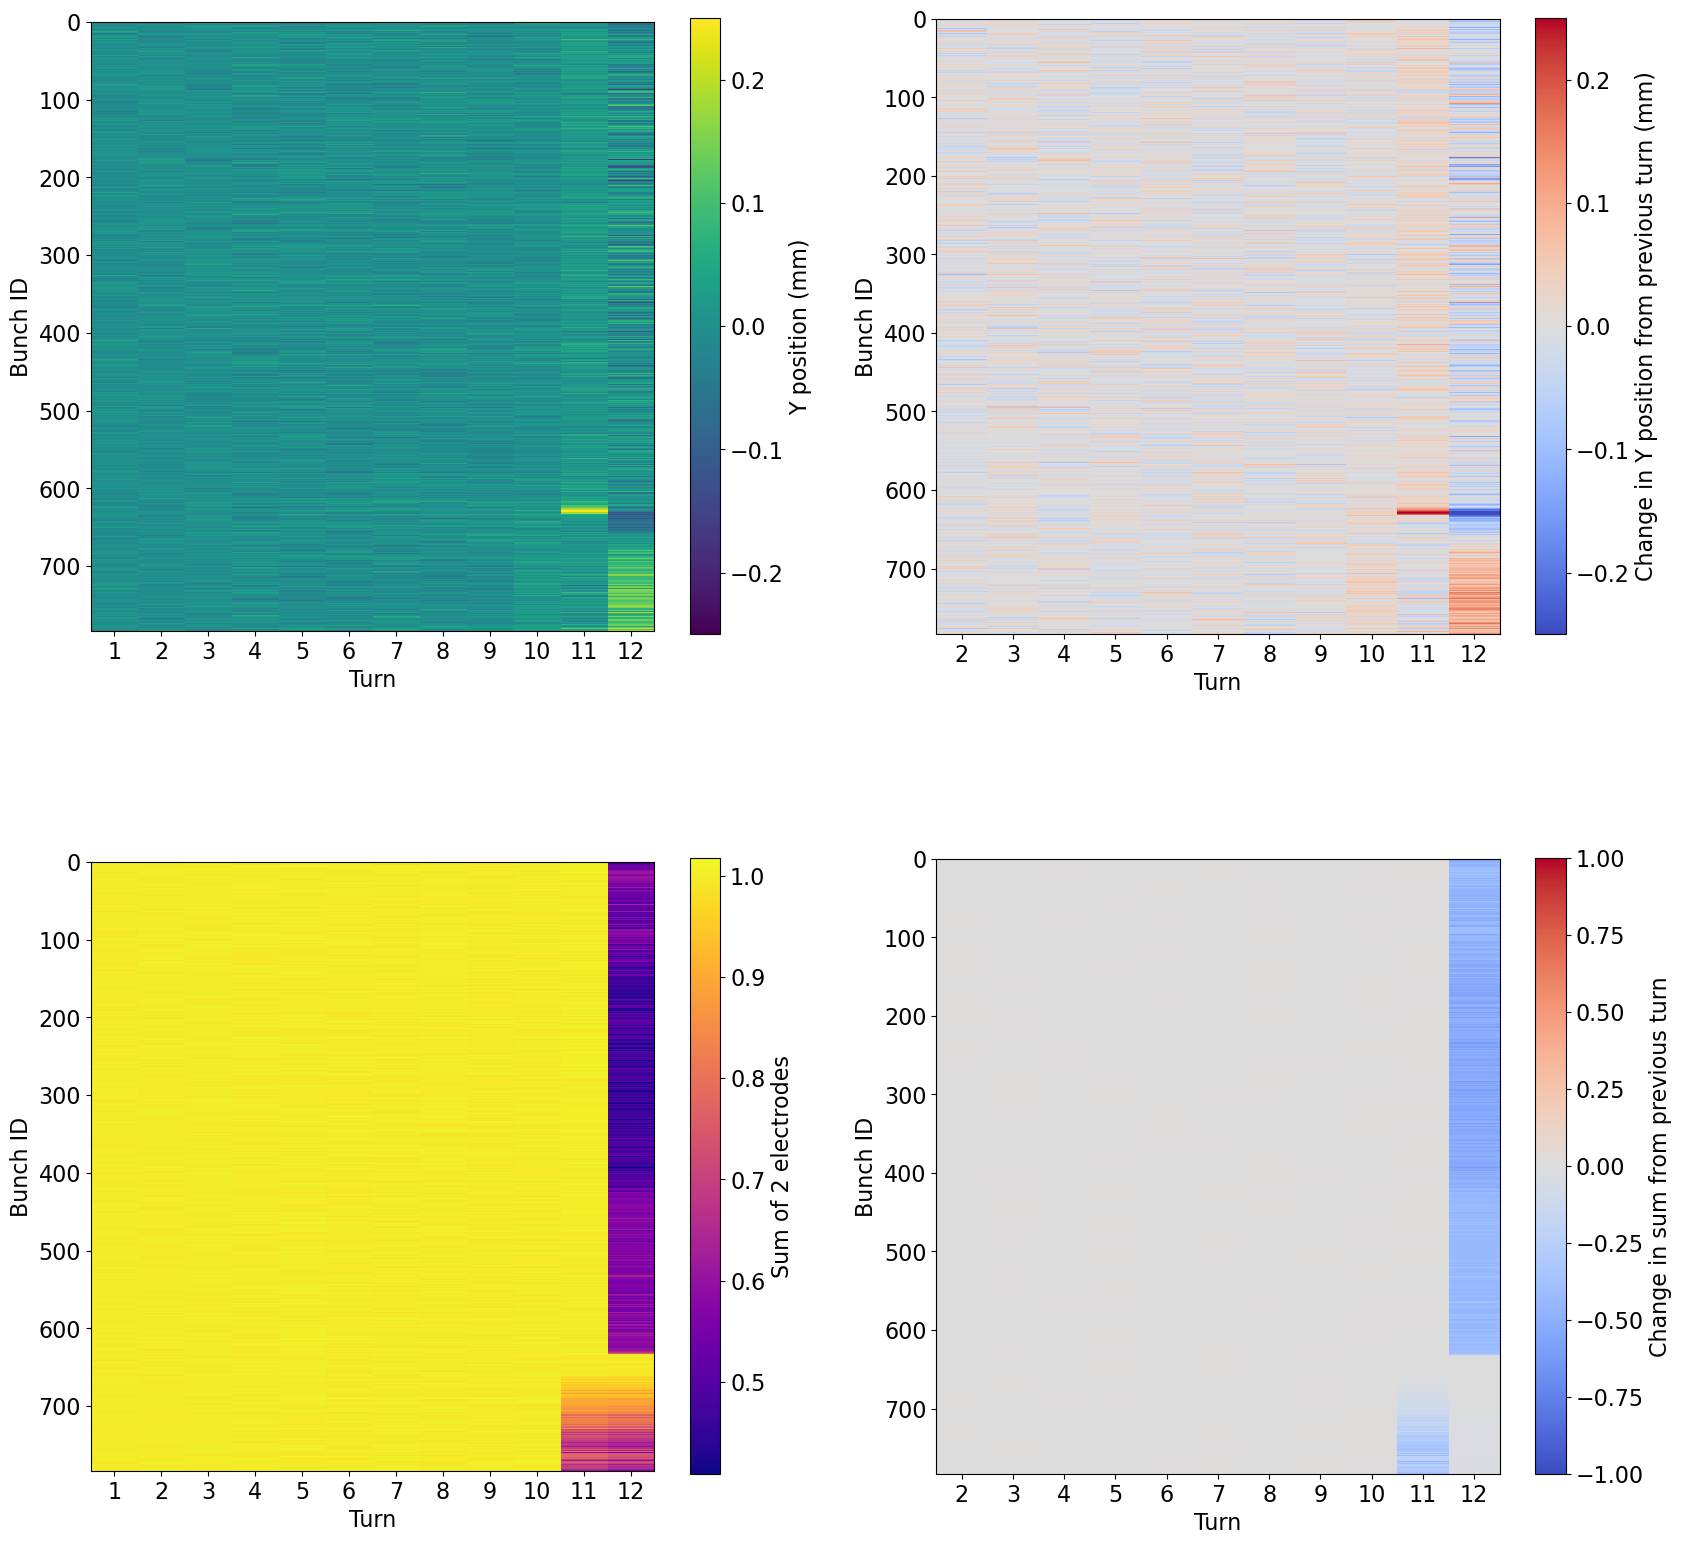

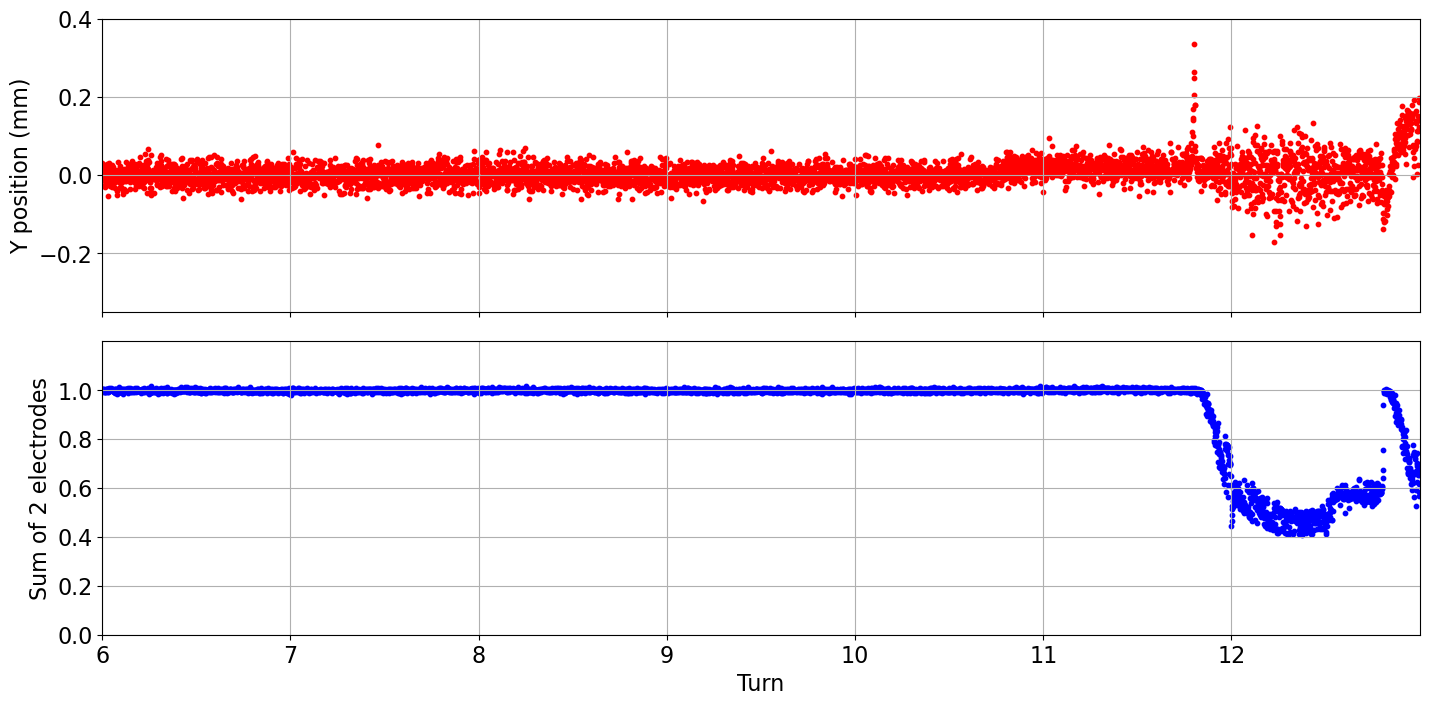

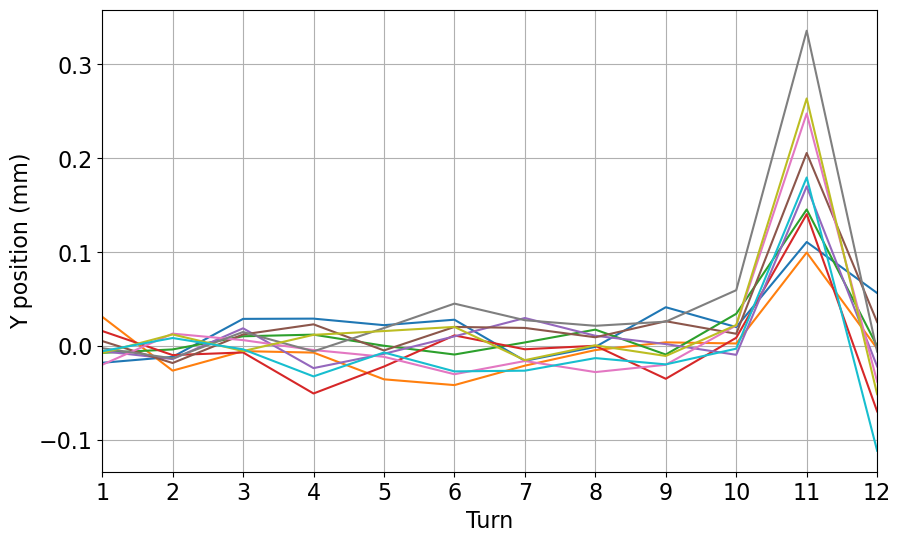

In [262]:
make_heatmap('data_20240307_191034.dat',1
             ,True,True,0.25,0.25,621,631)